# Sunspots Prediction

We evaluate the prediction accuracy of some simple models for the sunspots dataset. 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

        0     1    2  3  4
0  1700.5   8.3 -1.0 -1  1
1  1701.5  18.3 -1.0 -1  1
2  1702.5  26.7 -1.0 -1  1
3  1703.5  38.3 -1.0 -1  1
4  1704.5  60.0 -1.0 -1  1


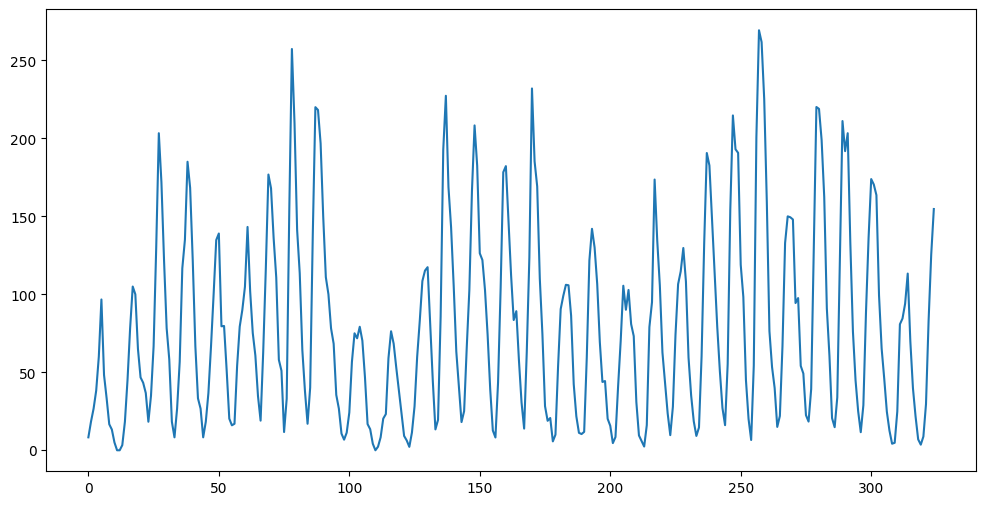

325


In [49]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header=None, sep=';')
print(sunspots.head())

y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()
print(n)

Let us split the dataset into two parts (training and test). We will fit models to the training data, and evaluate their prediction accuracy on the test dataset. 

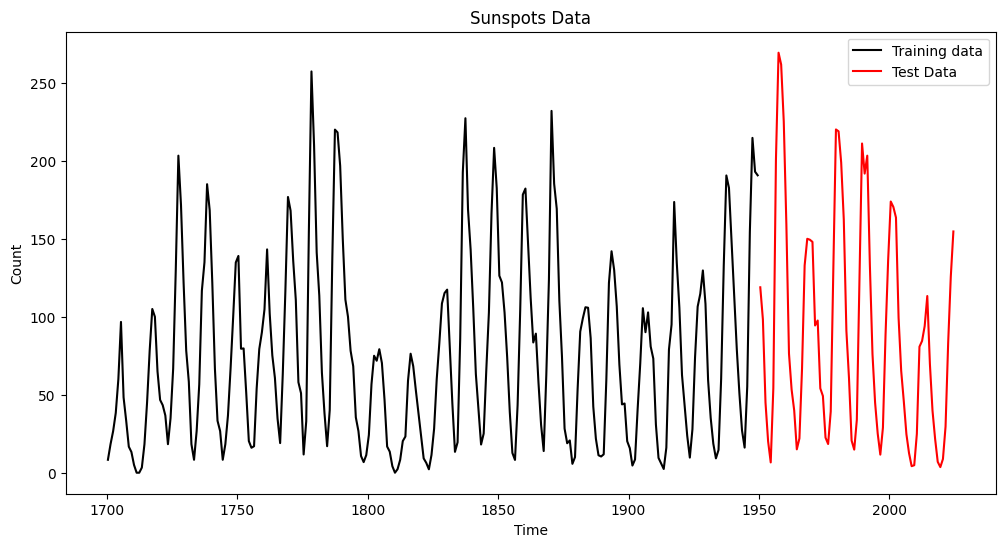

In [50]:
splitnumber = 250
sunspots_train = sunspots.iloc[:splitnumber, :].copy()
sunspots_test = sunspots.iloc[splitnumber:, :].copy()

#print(sunspots_train)
#print(sunspots_test)

tme_train = sunspots_train.iloc[:,0]
tme_test = sunspots_test.iloc[:,0]
tme = sunspots.iloc[:,0]

y =  sunspots_train.iloc[:,1].values

plt.figure(figsize = (12, 6))
plt.xlabel('Time')
plt.ylabel('Count')
plt.plot(tme, sunspots.iloc[:,1], color = "None")
plt.plot(tme_train, y, color = 'black', label = 'Training data')
plt.plot(tme_test, sunspots_test.iloc[:,1], color = 'red', label = 'Test Data')
plt.legend()
plt.title('Sunspots Data')
plt.show()

### Model One: Sinusoid Model

Our first model is the simple sinusoidal model that we studied way back in Lectures 5-8:
\begin{equation*}
  y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) + \epsilon_t
\end{equation*}
with $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$. The post estimate for $f$ can be obtained by the follwoing code

In [51]:
def rss(f):
    n = len(y)
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

allfvals = np.arange(0.01, 0.5, .0001) #much finer grid
rssvals = np.array([rss(f) for f in allfvals])
fhat = allfvals[np.argmin(rssvals)]
print(fhat)
print(1/fhat)

0.08989999999999951
11.123470522803176


The predictions with this model are obtained as follows. 

In [52]:
n = len(y)
x = np.arange(1, n+1)
xcos = np.cos(2 * np.pi * fhat * x)
xsin = np.sin(2 * np.pi * fhat * x)
X = np.column_stack([np.ones(n), xcos, xsin])
md = sm.OLS(y, X).fit()

t_future = np.arange(n+1, n+len(tme_test) + 1)
pred_test = (
    md.params[0] + md.params[1] * (np.cos(2 * np.pi * fhat * t_future)) 
    + md.params[2] * (np.sin(2 * np.pi * fhat * t_future))
)

# Prediction error:
pred_error_rms_sinusoid = np.sqrt(np.mean((pred_test - sunspots_test.iloc[:,1]) ** 2))
print(pred_error_rms_sinusoid)

79.83531765284938


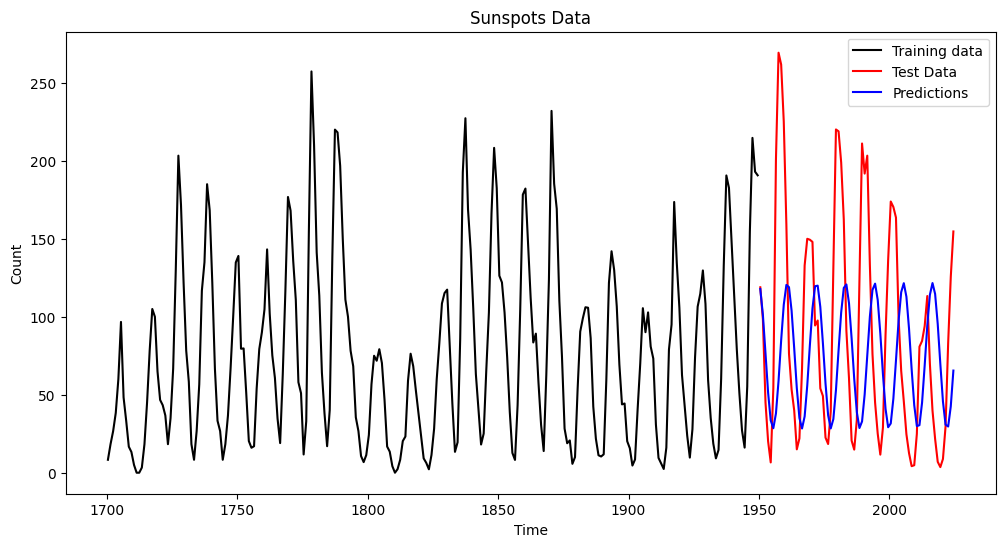

In [53]:
plt.figure(figsize = (12, 6))
plt.xlabel('Time')
plt.ylabel('Count')
plt.plot(tme, sunspots.iloc[:,1], color = "None")
plt.plot(tme_train, y, color = 'black', label = 'Training data')
plt.plot(tme_test, sunspots_test.iloc[:,1], color = 'red', label = 'Test Data')
plt.plot(tme_test, pred_test, color = 'blue', label = 'Predictions')
plt.legend()
plt.title('Sunspots Data')
plt.show()    

### Model Two: The Yule Model

This model is motivated by the following observation (discussed with proof in Lecture 16)
\begin{equation*}
   s_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) 
\end{equation*}
for $t = 1, 2, \dots$ is equivalent to (below $\omega = 2 \pi f$)
\begin{equation*}
   s_t = \alpha_0 + \alpha_1 s_{t-1} - s_{t-2} ~~~~ \text{ with } \alpha_0 = 2 \beta_0 (1 - \cos \omega) \text{ and } \alpha_1 = 2 \cos \omega.
\end{equation*}


This suggests that a different Sinusoid plus noise model is obtained by adding noise in the above equation leading to:
\begin{equation*}
   y_t = \alpha_0 + \alpha_1 y_{t-1} - y_{t-2} + \epsilon_t
\end{equation*}
The parameters $\alpha_0$ and $\alpha_1$ can be fit by least squares by minimizing 
\begin{equation*}
   \sum_{t=3}^n (y_t - \alpha_0 - \alpha_1 y_{t-1} + y_{t-2})^2 = \sum_{t=3}^n (y_t + y_{t-2} - \alpha_0 - \alpha_1 y_{t-1} )^2
\end{equation*}
Note that the time index goes from $3$ to $n$ above (because we do not have access to $y_{t-1}$ and/or $y_{t-2}$ when $t \leq 2$). This least squares estimator can be computed by creating a new response variable $y_t + y_{t-2}$ and regressing it on $y_{t-1}$ (and the constant term).

In [54]:
p = 2
yreg = y[p:]
x1 = y[1:-1]
x2 = y[:-2]
Xmat = np.column_stack([np.ones(len(yreg)), x1])
print(Xmat.shape)

(248, 2)


In [55]:
y_adjusted = yreg + x2
yulemod = sm.OLS(y_adjusted, Xmat).fit()
print(yulemod.summary())
print(yulemod.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     3090.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):          2.78e-141
Time:                        15:10:08   Log-Likelihood:                -1168.0
No. Observations:                 248   AIC:                             2340.
Df Residuals:                     246   BIC:                             2347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3114      2.791      9.787      0.0

Because $\alpha_1 = 2 \cos \omega = 2 \cos (2 \pi f)$, we can obtain an estimate of $f$ from the least squares estimate of $\alpha_1$ obtained above. 

In [56]:
alpha1_hat = yulemod.params[1]
yulefhat = np.arccos(alpha1_hat/2) / (2 * np.pi)
print(1/yulefhat)

10.234141128185033


It is interesting that the period corresponding to this estimate of $f$ is less than 11 by a nontrivial amount. 

We now obtain predictions for the test times from the Yule model. 

In [57]:
# Generate k-step ahead forecasts: 
k = len(tme_test)
yhat = np.concatenate([y, np.full(k, -9999)]) # extend data by k placeholder values
for i in range(1, k+1):
    ans = yulemod.params[0] - yhat[n+i-3]
    ans += yulemod.params[1] * yhat[n+i-2]
    yhat[n+i-1] = ans
predvalues_yulemod = yhat[n:]
print(predvalues_yulemod)

[146.06104972  75.38685636   4.49010921 -40.73521796 -43.77125261
  -3.50912861  65.34601702 137.64587487 186.98400606 195.34039803
 159.66300392  92.98245693  19.65282692 -33.5433384  -47.17693735
 -16.26850237  47.89312417 121.87387032 178.65337795 197.49378336
 171.513911   110.20251965  35.9526756  -24.11697905 -48.06690374
 -27.14974761  30.99481172 105.13034589 168.17996275 197.11573524
 181.36930636 126.69182313  53.05341637 -12.65059012 -46.42279325
 -35.92840227  14.99966389  87.76069276 155.77980967 194.21405216
 189.02588952 142.11022034  70.60228927   0.6192958  -42.27852115
 -42.42337723   0.23763408  70.12321812 141.70871333 188.84859105
 194.32571784 156.13965529  88.2372901   15.41894292 -35.71957693
 -46.50069192 -12.98676148  52.58175387 126.25693714 181.13003247
 197.15946465 168.49072395 105.59463801  31.44305903 -26.88126073
 -48.07623808 -24.4007254   35.49815135 109.74322567 171.21759752
 197.46867444 178.90864425 122.31627964  48.36109315 -15.94589238]


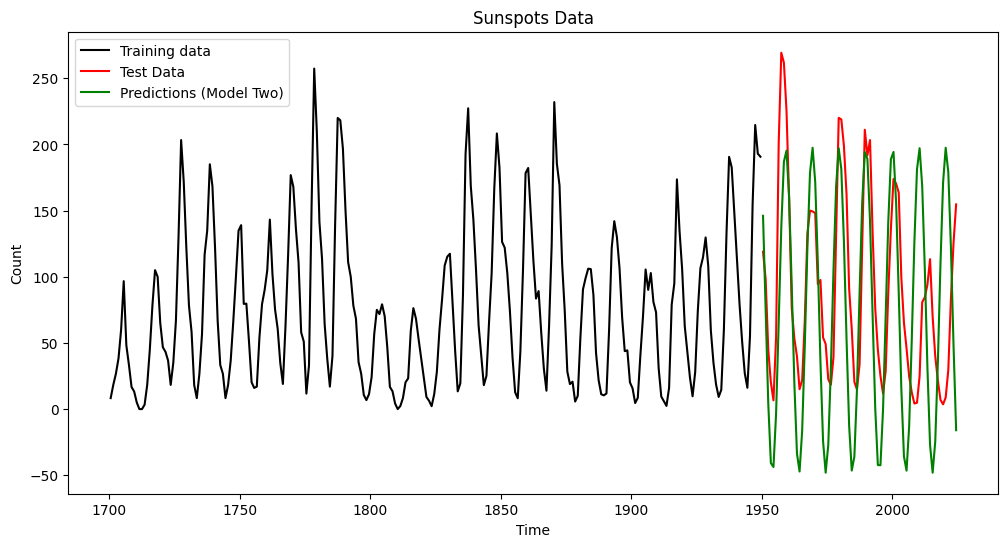

In [58]:
plt.figure(figsize = (12, 6))
plt.xlabel('Time')
plt.ylabel('Count')
plt.plot(tme, sunspots.iloc[:,1], color = "None")
plt.plot(tme_train, y, color = 'black', label = 'Training data')
plt.plot(tme_test, sunspots_test.iloc[:,1], color = 'red', label = 'Test Data')
#plt.plot(tme_test, pred_test, color = 'blue', label = 'Predictions (Model One)')
plt.plot(tme_test, predvalues_yulemod, color = 'green', label = 'Predictions (Model Two)')
plt.legend()
plt.title('Sunspots Data')
plt.show()    

In [59]:
pred_error_rms_yulemod = np.sqrt(np.mean((predvalues_yulemod - sunspots_test.iloc[:,1]) ** 2))
print(pred_error_rms_sinusoid, pred_error_rms_yulemod)
# basically the same prediction errors (slightly smaller for the Yule model); expect different results for different training-test splits. 

79.83531765284938 79.52702577862316


### Model Three: AR(2)

The AR(2) model is a natural extension of the Yule model: 
\begin{equation*}
   y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t
\end{equation*}
The only difference between the Yule model and AR(2) is that $\phi_2 = -1$ in the Yule model while it is treated as an adjustable parameter which can provide better fits to the data in AR(2). 

The AR(2) model is fit in the following way. 

In [60]:
p = 2
yreg = y[p:] # these are the response values in the autoregression
Xmat = np.ones((n-p, 1)) # this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y[p-j : n-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

In [61]:
armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2))
print(sighat)

[23.08524521  1.37838349 -0.68406411]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     567.0
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           1.19e-92
Time:                        15:10:09   Log-Likelihood:                -1147.2
No. Observations:                 248   AIC:                             2300.
Df Residuals:                     245   BIC:                             2311.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

Note that the estimated value of $\phi_2$ (which is the value of $\phi_2$ which gives the best fit to the data in the least squares sense) is $-0.6841$ which is quite a bit smaller than the value of $-1$ which is hard-coded in the Yule model. 

Let us obtain predictions for the future values using the fitted AR(2) model.

In [62]:
# Generate k-step ahead forecasts: 
k = len(tme_test)
yhat = np.concatenate([y, np.full(k, -9999)]) # extend data by k placeholder values
for i in range(1, k+1):
    ans = armod.params[0]
    for j in range(1, p+1):
        ans += armod.params[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues_ar = yhat[n:]

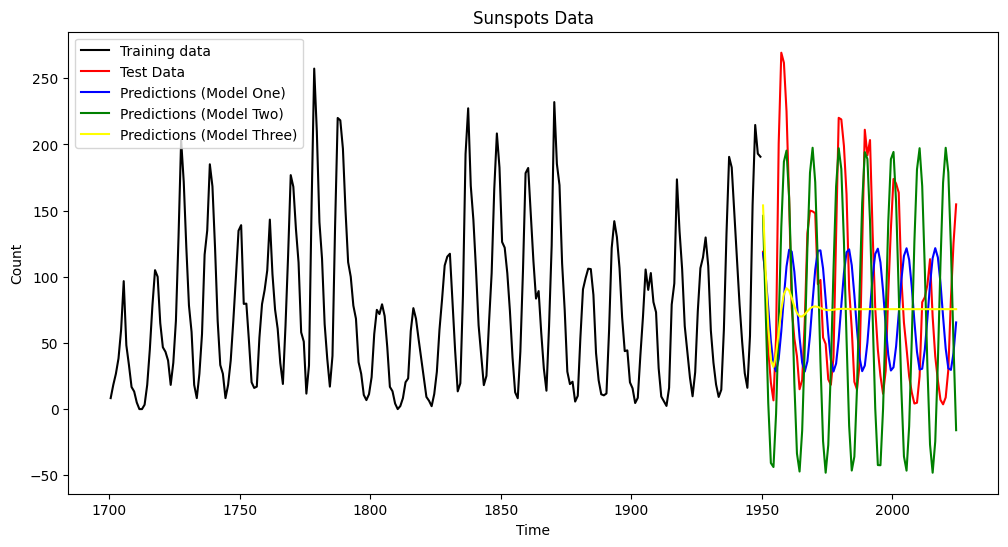

In [63]:
plt.figure(figsize = (12, 6))
plt.xlabel('Time')
plt.ylabel('Count')
plt.plot(tme, sunspots.iloc[:,1], color = "None")
plt.plot(tme_train, y, color = 'black', label = 'Training data')
plt.plot(tme_test, sunspots_test.iloc[:,1], color = 'red', label = 'Test Data')
plt.plot(tme_test, pred_test, color = 'blue', label = 'Predictions (Model One)')
plt.plot(tme_test, predvalues_yulemod, color = 'green', label = 'Predictions (Model Two)')
plt.plot(tme_test, predvalues_ar, color = 'yellow', label = 'Predictions (Model Three)')
plt.legend()
plt.title('Sunspots Data')
plt.show()    

The predictions look quite different. For AR(2), the predictions die out to a constant value. 

In [64]:
pred_error_rms_ar = np.sqrt(np.mean((predvalues_ar - sunspots_test.iloc[:,1]) ** 2))
print(pred_error_rms_sinusoid, pred_error_rms_yulemod, pred_error_rms_ar)

79.83531765284938 79.52702577862316 70.32365837557232


It is interesting that even though the predictions of the AR model die out to a constant value, in terms of prediction accuracy, it performs better than the previous two sinusoidal models. One reason for this is that the cycles of the sunspots data are irregular (and their periodicity changes from cycle to cycle). If we use a single sinusoid for prediction (as in Models One and Two), there is a danger that the predictions go out of phase with the actual data. The AR model, by predicting a constant, becomes more accurate than a sinusoidal model that goes out of phase. Note though that this prediction comparison will change if we change the training and test datasets. 

### Model Four: AR($p$) for a higher $p$

We can see how the predictions change if we use $AR(p)$ for a higher $p$. The AR(p) for $p \geq 2$ should give better fits to the data. Unless there is overfitting, this should lead to better predictions as well. 

In [65]:
p = 12
yreg = y[p:] # these are the response values in the autoregression
Xmat = np.ones((n-p, 1)) # this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y[p-j : n-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

In [66]:
armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2))
print(sighat)

[13.12906966  1.21947938 -0.50695376 -0.10670251  0.16956741 -0.15634832
  0.05883931 -0.05974739  0.10456934  0.09940318 -0.06642164  0.14368696
 -0.06191045]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     106.0
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           2.00e-85
Time:                        15:10:09   Log-Likelihood:                -1082.3
No. Observations:                 238   AIC:                             2191.
Df Residuals:                     225   BIC:                             2236.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

In [67]:
# Generate k-step ahead forecasts: 
k = len(tme_test)
yhat = np.concatenate([y, np.full(k, -9999)]) # extend data by k placeholder values
for i in range(1, k+1):
    ans = armod.params[0]
    for j in range(1, p+1):
        ans += armod.params[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues_ar_high = yhat[n:]


In [68]:
pred_error_rms_ar_high = np.sqrt(np.mean((predvalues_ar_high - sunspots_test.iloc[:,1]) ** 2))
print(pred_error_rms_sinusoid, pred_error_rms_yulemod, pred_error_rms_ar, pred_error_rms_ar_high)

79.83531765284938 79.52702577862316 70.32365837557232 50.162969939451365


With $p = 12$, the prediction accuracy is much better compared to $p = 2$ (as well as models 1 and 2).

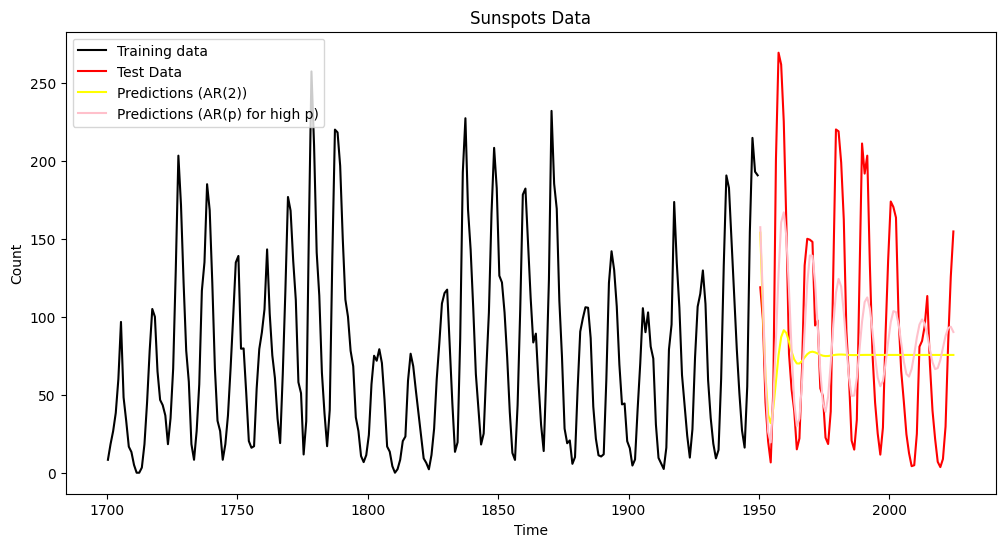

In [69]:
plt.figure(figsize = (12, 6))
plt.xlabel('Time')
plt.ylabel('Count')
plt.plot(tme, sunspots.iloc[:,1], color = "None")
plt.plot(tme_train, y, color = 'black', label = 'Training data')
plt.plot(tme_test, sunspots_test.iloc[:,1], color = 'red', label = 'Test Data')
#plt.plot(tme_test, pred_test, color = 'blue', label = 'Predictions (Model One)')
#plt.plot(tme_test, predvalues_yulemod, color = 'green', label = 'Predictions (Model Two)')
plt.plot(tme_test, predvalues_ar, color = 'yellow', label = 'Predictions (AR(2))')
plt.plot(tme_test, predvalues_ar_high, color = 'pink', label = 'Predictions (AR(p) for high p)')
plt.legend()
plt.title('Sunspots Data')
plt.show()    